In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.transforms import ToPILImage

from PIL import Image
from pathlib import Path
from typing import Tuple, List
from IPython.display import clear_output
from tqdm import tqdm

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
import requests

In [3]:
# Путь к локальному расположению каталога
DATASET_PATH = Path('C:/Users/oigla/#Notebooks/data.lens/data.lens-1/datasets/face-mask-detection/Face Mask Dataset')

In [4]:
# Какие форматы файлов в каждой из папок
np.unique([path.suffix for path in DATASET_PATH.glob('./*/*/*')])

array(['.png'], dtype='<U4')

In [5]:
# Список преобученных моделей из списка Torchvision
dir(torchvision.models)[:5]

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights']

In [6]:
# Загрузка предобученных весов и аугментаций
weight = ResNet101_Weights.DEFAULT
weight_transforms = weight.transforms()

In [7]:
weight

ResNet101_Weights.IMAGENET1K_V2

In [8]:
weight_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
# Создание датасетов с применением аугментаций
train_dataset = ImageFolder(DATASET_PATH / 'Train', transform=weight_transforms)
valid_dataset = ImageFolder(DATASET_PATH / 'Validation', transform=weight_transforms)
test_dataset = ImageFolder(DATASET_PATH / 'Test', transform=weight_transforms)

In [10]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: C:\Users\oigla\#Notebooks\data.lens\data.lens-1\datasets\face-mask-detection\Face Mask Dataset\Train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [11]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 800
    Root location: C:\Users\oigla\#Notebooks\data.lens\data.lens-1\datasets\face-mask-detection\Face Mask Dataset\Validation
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [12]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 992
    Root location: C:\Users\oigla\#Notebooks\data.lens\data.lens-1\datasets\face-mask-detection\Face Mask Dataset\Test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [13]:
# Соединение датасетов для валидации и тестирования в один датасет
val_dataset = ConcatDataset([valid_dataset, test_dataset])
val_dataset[0]

(tensor([[[-1.9638, -1.9980, -2.0323,  ..., -1.7925, -1.7925, -1.7754],
          [-1.9809, -1.9980, -2.0494,  ..., -1.7925, -1.7754, -1.7754],
          [-1.9980, -2.0323, -2.0665,  ..., -1.7925, -1.7754, -1.7754],
          ...,
          [-2.0323, -1.9980, -2.0152,  ..., -2.0665, -2.0665, -2.0665],
          [-2.0323, -1.9980, -2.0152,  ..., -2.0665, -2.0665, -2.0837],
          [-2.0494, -2.0152, -2.0323,  ..., -2.0837, -2.0837, -2.1008]],
 
         [[-1.7206, -1.7556, -1.7906,  ..., -1.6681, -1.6681, -1.6506],
          [-1.7381, -1.7556, -1.8081,  ..., -1.6681, -1.6506, -1.6506],
          [-1.7731, -1.8081, -1.8431,  ..., -1.6681, -1.6681, -1.6506],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.9307, -1.9307, -1.9307],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9307, -1.9307, -1.9482],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9307, -1.9307, -1.9482]],
 
         [[-1.3687, -1.4384, -1.4733,  ..., -1.6650, -1.6650, -1.6650],
          [-1.4036, -1.4384,

In [14]:
# Подсчет количества изображений в каждом датасете
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)

print(f"Количество изображений в обучающем датасете: {num_train_images}")
print(f"Количество изображений в валидационном датасете: {num_val_images}")

Количество изображений в обучающем датасете: 10000
Количество изображений в валидационном датасете: 1792


In [15]:
# Создание DataLoader'ов для обучения и валидации
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [16]:
train_dataset.class_to_idx.items()

dict_items([('WithMask', 0), ('WithoutMask', 1)])

In [17]:
# Преобразуем словарь из индексов в классы
index_to_class = {value: key for key, value in train_dataset.class_to_idx.items()}
index_to_class

{0: 'WithMask', 1: 'WithoutMask'}

In [18]:
# Получение одного батча из DataLoader для проверки
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

# Количество объектов в одном батче
num_train_objects_in_batch = len(train_batch[0])
num_val_objects_in_batch = len(val_batch[0])

print(f"Количество объектов в одном батче обучающего набора: {num_train_objects_in_batch}")
print(f"Количество объектов в одном батче валидационного набора: {num_val_objects_in_batch}")

Количество объектов в одном батче обучающего набора: 64
Количество объектов в одном батче валидационного набора: 64


In [19]:
train_batch

[tensor([[[[-1.2788, -1.2617, -1.1247,  ...,  2.2489,  2.2489,  2.2489],
           [-1.1247, -1.1075, -1.1075,  ...,  2.2489,  2.2489,  2.2489],
           [-1.0048, -0.9705, -1.1075,  ...,  2.2489,  2.2489,  2.2489],
           ...,
           [-1.9467, -1.9467, -1.9467,  ..., -0.5596, -0.2342,  0.2624],
           [-1.9467, -1.9467, -1.9467,  ..., -1.2103, -1.1932, -0.7137],
           [-1.9467, -1.9295, -1.9295,  ..., -1.2959, -1.2274, -0.9363]],
 
          [[-1.5280, -1.5280, -1.3880,  ...,  2.3761,  2.3761,  2.3761],
           [-1.3704, -1.3704, -1.3704,  ...,  2.3761,  2.3761,  2.3761],
           [-1.2479, -1.2304, -1.3704,  ...,  2.3761,  2.3761,  2.3761],
           ...,
           [-1.9307, -1.9132, -1.8957,  ..., -0.4426, -0.1099,  0.3978],
           [-1.9307, -1.9132, -1.8957,  ..., -1.1078, -1.0903, -0.6001],
           [-1.9307, -1.9132, -1.8957,  ..., -1.1954, -1.1253, -0.8277]],
 
          [[-1.5953, -1.5953, -1.4559,  ...,  2.5354,  2.5354,  2.5529],
           [-

In [20]:
# Иициализация модели
model = torchvision.models.resnet101(weights=weight)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# кол-во всех параметров модели
num_params = sum(param.numel() for param in model.parameters())
f'{num_params:,}'

'44,549,160'

In [23]:
len_trainable_params = sum(param.requires_grad for param in model.parameters())
print("Изначальное количество обучаемых параметров:", len_trainable_params)

Изначальное количество обучаемых параметров: 314


In [24]:
# отключить градиенты у всех весов модели
model.requires_grad_(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
len_trainable_params_after_freeze = sum(param.requires_grad for param in model.parameters())
print("Количество обучаемых параметров после отключения градиентов:", len_trainable_params_after_freeze)

Количество обучаемых параметров после отключения градиентов: 0


In [26]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [27]:
model.fc.in_features

2048

In [28]:
in_size = model.fc.in_features

In [29]:
model.fc = nn.Sequential(
    nn.Linear(in_size, 1),  # Один выходной нейрон
    nn.Sigmoid()            # Функция активации Sigmoid для выхода от 0 до 1
)
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)

In [30]:
len_trainable_params_after_freeze = sum(param.requires_grad for param in model.parameters())
print("Количество обучаемых параметров после отключения градиентов:", len_trainable_params_after_freeze)

Количество обучаемых параметров после отключения градиентов: 2


In [31]:
# Определение функции потерь и оптимизатора
loss_fn = nn.BCELoss()
opt = optim.Adam(model.fc.parameters())

In [32]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

#### Класс тренера

In [33]:
class BinaryClassifierTrainer:
    """Класс для тренировки моделей для задачи бинарной классификации"""
    def __init__(self,
            model: nn.Module,
            opt: torch.optim.Optimizer,
            loss_fn: nn.Module,
            scheduler: torch.optim.lr_scheduler._LRScheduler = None):

        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.opt = opt
        self.scheduler = scheduler
        self.loss_fn = loss_fn

        self.init_log()

    def init_log(self) -> None:
        """Инициализация словаря для хранения значений ошибки и accuracy"""
        metrics_names = ('train_loss', 'val_loss', 'train_acc', 'val_acc')
        self.metrics = {key: [] for key in metrics_names}
        self.best_acc = 0

    @torch.inference_mode()
    def get_acc_from_logits(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Вычисляет accuracy из логитов"""
        preds = (logits > 0.5).float()
        return (preds == targets).sum()

    def train_batch(self, batch: Tuple[torch.Tensor, torch.Tensor], is_train: bool) -> Tuple[float, float]:
        """Вычисляет ошибку и accuracy по одному батчу"""
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device).float().view(-1, 1)

        logits = self.model(inputs)
        batch_loss = self.loss_fn(logits, targets)
        batch_acc = self.get_acc_from_logits(logits, targets)

        if is_train:
            self.opt.zero_grad()
            batch_loss.backward()
            self.opt.step()

            if self.scheduler is not None:
                self.scheduler.step()

        return batch_loss.item(), batch_acc.item()

    def train_val_epoch(self, loader: DataLoader, is_train: bool) -> Tuple[float, float]:
        """Делает один проход по даталоадеру, и вычисляет ошибку и accuracy по всем данным"""
        epoch_loss, epoch_acc = 0, 0

        desc = 'Train' if is_train else 'Validation'
        self.model.train(is_train)

        with torch.inference_mode(not is_train):
            for batch in tqdm(loader, desc=desc, leave=False):
                batch_loss, batch_acc = self.train_batch(batch, is_train)
                epoch_loss += batch_loss
                epoch_acc += batch_acc

        return epoch_loss / len(loader), epoch_acc / len(loader.dataset)

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader, best_checkpoint: str = '') -> str:
        """Производит тренировку модели и отрисовывает графики ошибок и accuracy. Сохраняет параметры модели и оптимизатора"""
        if best_checkpoint:
            self.load_checkpoint(best_checkpoint)

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_val_epoch(train_loader, is_train=True)
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)

            val_loss, val_acc = self.train_val_epoch(val_loader, is_train=False)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)

            # сохранение весов если метрика выше чем self.best_acc
            if val_acc > self.best_acc:
                best_checkpoint = self.save_checkpoint()
                self.best_acc = val_acc

            clear_output(True)
            self.plot_metrics()

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_checkpoint

    def save_checkpoint(self) -> str:
        """Сохраняет параметры модели и оптимизатора"""
        checkpoint_path = "best_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'best_acc': self.best_acc,
        }, checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path: str) -> None:
        """Загружает параметры модели и оптимизатора"""
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_acc = checkpoint['best_acc']

    def plot_metrics(self) -> None:
        """Отрисовывает графики ошибок и точности"""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train_acc'], label='Train Accuracy')
        plt.plot(self.metrics['val_acc'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.show()


#### Класс тренера 2-й вариант

In [33]:
class BinaryClassifierTrainer:
    """Класс для тренировки моделей для задачи бинарной классификации"""
    def __init__(self,
                 model: nn.Module,
                 opt: torch.optim.Optimizer,
                 loss_fn: nn.Module,
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None):

        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.opt = opt
        self.scheduler = scheduler
        self.loss_fn = loss_fn

        self.init_log()

    def init_log(self) -> None:
        """Инициализация словаря для хранения значений ошибки и accuracy"""
        metrics_names = ('train_loss', 'val_loss', 'train_acc', 'val_acc')
        self.metrics = {key: [] for key in metrics_names}
        self.best_acc = 0

    @torch.inference_mode()
    def get_acc_from_logits(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Вычисляет accuracy из логитов"""
        preds = (logits > 0.5).float()
        return (preds == targets).sum()

    def train_batch(self, batch: Tuple[torch.Tensor, torch.Tensor], is_train: bool) -> Tuple[float, float]:
        """Вычисляет ошибку и accuracy по одному батчу"""
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device).float().view(-1, 1)

        logits = self.model(inputs)
        batch_loss = self.loss_fn(logits, targets)
        batch_acc = self.get_acc_from_logits(logits, targets)

        if is_train:
            self.opt.zero_grad()
            batch_loss.backward()
            self.opt.step()

            if self.scheduler is not None:
                self.scheduler.step()

        return batch_loss.item(), batch_acc.item()

    def train_val_epoch(self, loader: DataLoader, is_train: bool) -> Tuple[float, float]:
        """Делает один проход по даталоадеру, и вычисляет ошибку и accuracy по всем данным"""
        epoch_loss, epoch_acc = 0, 0

        desc = 'Train' if is_train else 'Validation'
        self.model.train(is_train)

        with torch.inference_mode(not is_train):
            for batch in tqdm(loader, desc=desc, leave=False):
                batch_loss, batch_acc = self.train_batch(batch, is_train)
                epoch_loss += batch_loss
                epoch_acc += batch_acc

        return epoch_loss / len(loader), epoch_acc / len(loader.dataset)

    def train(self, epochs: int, train_loader: DataLoader, val_loader: DataLoader, best_checkpoint: str = '') -> str:
        """Производит тренировку модели и отрисовывает графики ошибок и accuracy. Сохраняет параметры модели и оптимизатора"""
        if best_checkpoint:
            self.load_checkpoint(best_checkpoint)

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self.train_val_epoch(train_loader, is_train=True)
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_acc'].append(train_acc)

            val_loss, val_acc = self.train_val_epoch(val_loader, is_train=False)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_acc'].append(val_acc)

            # сохранение весов если метрика выше чем self.best_acc
            if val_acc > self.best_acc:
                best_checkpoint = self.save_checkpoint()
                self.best_acc = val_acc

            clear_output(True)
            self.plot_metrics()

            print(f"Epoch {epoch}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        return best_checkpoint

    def save_checkpoint(self) -> str:
        """Сохраняет параметры модели и оптимизатора"""
        checkpoint_path = "best_model.pth"
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'best_acc': self.best_acc,
        }, checkpoint_path)
        return checkpoint_path

    def load_checkpoint(self, checkpoint_path: str) -> None:
        """Загружает параметры модели и оптимизатора"""
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_acc = checkpoint['best_acc']

    def plot_metrics(self) -> None:
        """Отрисовывает графики ошибок и точности"""
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['train_acc'], label='Train Accuracy')
        plt.plot(self.metrics['val_acc'], label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()

        plt.show()

#### Инференс

In [34]:
def inference(model: nn.Module, images: List[Image.Image], true_labels: List[int], class_names: List[str], transform) -> None:
    """Выполняет инференс и отображает результаты на изображениях"""
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for image, true_label in zip(images, true_labels):
        # Преобразование изображения в тензор
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
            probability = output.item()
        
        pred_label = 1 if probability > 0.5 else 0
        probability = round(probability, 4)

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f'True: {class_names[true_label]}\nPrediction: {class_names[pred_label]} ({probability})')
        plt.axis('on')
        plt.show()

#### Обучение

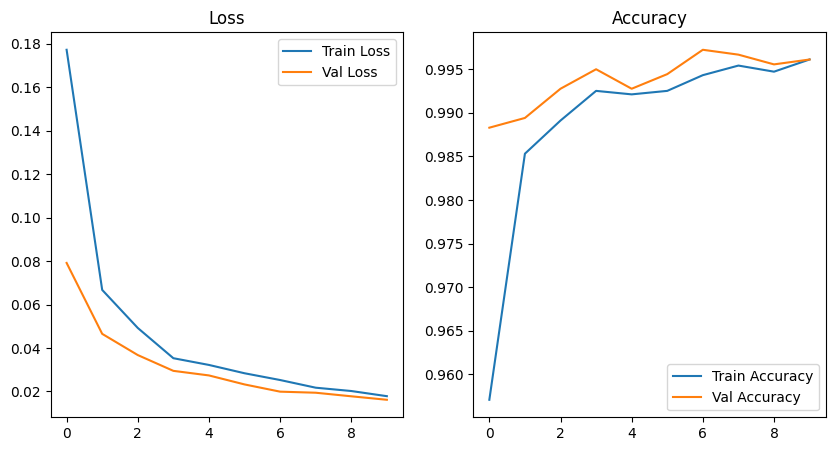

Epoch 10/10
Train Loss: 0.0178, Train Acc: 0.9961
Val Loss: 0.0162, Val Acc: 0.9961
CPU times: total: 44min 52s
Wall time: 10min 48s


In [35]:
%%time
# Объект тренера
trainer = BinaryClassifierTrainer(model, opt, loss_fn)
# Обучение модели
EPOCHS = 10
best_checkpoint = trainer.train(EPOCHS, train_loader, val_loader)

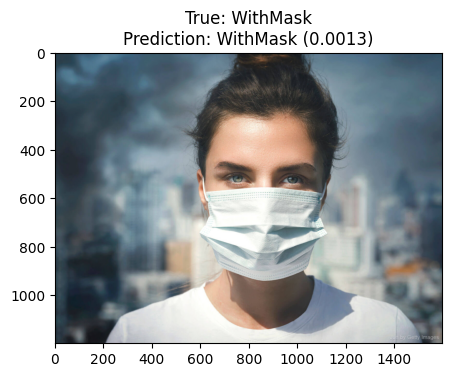

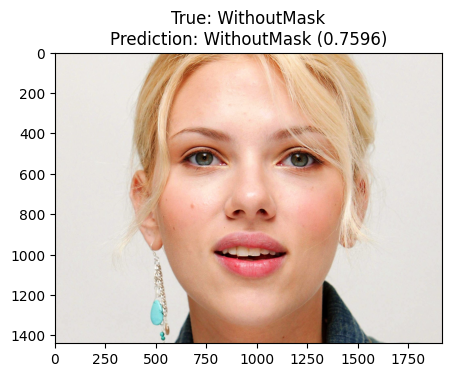

In [36]:
# Пример изображений для инференса
image_url1 = 'C:/Users/oigla/OneDrive/Фотографии/maska.jpg'
image_url3 = 'C:/Users/oigla/OneDrive/Фотографии/_maska_.jpg'

sample_images = [
    Image.open(image_url1).convert('RGB'), 
    Image.open(image_url3).convert('RGB'),
]
true_labels = [0, 1]  # Истинные метки для этих изображений
class_names = ['WithMask', 'WithoutMask']

# Трансформации для инференса
data_transforms = transforms.Compose([
    transforms.Resize((224, 232)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Выполнение инференса и отображение результатов
inference(model, sample_images, true_labels, class_names, transform=data_transforms)

In [37]:
data_transforms

Compose(
    Resize(size=(224, 232), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [38]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1, bias=True)
  (1): Sigmoid()
)